In [1]:
import pickle
from USPTO_CONFIG import USPTO_CONFIG
import pandas as pd
from rdkit import Chem
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [3]:
with open(USPTO_CONFIG.reactant_dict, 'rb') as handle:
    reactant_dict = pickle.load(handle)

with open(USPTO_CONFIG.full_dict, 'rb') as handle:
    full_dict = pickle.load(handle)

In [4]:
print("Number of distinct molecules in reactants:{}\nNumber of distinct molecules in reactants+products:{}".format(len(reactant_dict), len(full_dict)))

Number of distinct molecules in reactants:692559
Number of distinct molecules in reactants+products:1260895


In [5]:
def dict_process(reactant_dict, full_dict):
    reactant_df = pd.DataFrame(data=reactant_dict)
    reactant_df = reactant_df.transpose()

    full_df = pd.DataFrame(data=full_dict)
    full_df = full_df.transpose()

    return reactant_df, full_df

In [6]:
reactant_df, full_df = dict_process(reactant_dict, full_dict)

In [7]:
reactant_df = reactant_df.rename_axis('inchi').reset_index()
full_df = full_df.rename_axis('inchi').reset_index()

In [1]:

plt.hist(reactant_df['count'], bins=40)
plt.title("Reactants appearance frequency distribtuion in USPTO")
plt.show()

plt.hist(reactant_df[reactant_df['count'] < 10]['count'], bins=40)
plt.title("Reactants appearance frequency < 10 distribtuion in USPTO")
plt.show()

plt.hist(reactant_df[(reactant_df['count'] > 10) & (reactant_df['count'] < 100)]['count'], bins=40)
plt.title("Reactants appearance frequency > 10 & < 100 distribtuion in USPTO")
plt.show()

plt.hist(reactant_df[(reactant_df['count'] > 100) & (reactant_df['count'] < 2000)]['count'], bins=40)
plt.title("Reactants appearance frequency > 100 & < 2000 distribtuion in USPTO")
plt.show()

plt.hist(reactant_df[(reactant_df['count'] > 2000) & (reactant_df['count'] < 10000)]['count'], bins=40)
plt.title("Reactants appearance frequency > 2000 & < 10000 distribtuion in USPTO")
plt.show()

plt.hist(reactant_df[reactant_df['count'] > 10000]['count'], bins=40)
plt.title("Reactants appearance frequency > 10000 distribtuion in USPTO")
plt.show()

plt.hist(reactant_df['atoms'], bins=40)
plt.title("Size distribution for reactants molecules in USPTO")
plt.show()

NameError: name 'plt' is not defined

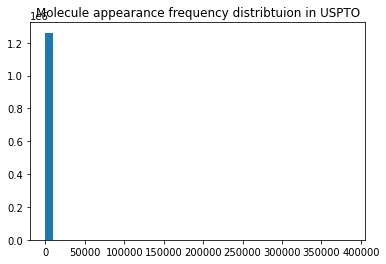

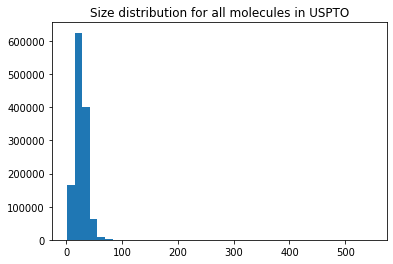

In [9]:

plt.hist(full_df['count'], bins=40)
plt.title("Molecule appearance frequency distribtuion in USPTO")
plt.show()

plt.hist(full_df['atoms'], bins=40)
plt.title("Size distribution for all molecules in USPTO")
plt.show()

In [10]:
reactant_df[['count', 'atoms']].describe()

,count,atoms
count,692559.000000,692559.000000
mean,9.786950,23.445758
std,775.331692,10.144402
min,1.000000,1.000000
25%,1.000000,16.000000
50%,2.000000,22.000000
75%,3.000000,29.000000
max,381370.000000,547.000000


In [11]:
full_df[['count', 'atoms']].describe()

,count,atoms
count,1.260895e+06,1.260895e+06
mean,7.022154e+00,2.567368e+01
std,6.016513e+02,1.007612e+01
min,1.000000e+00,1.000000e+00
25%,1.000000e+00,1.800000e+01
50%,2.000000e+00,2.500000e+01
75%,3.000000e+00,3.200000e+01
max,3.859490e+05,5.470000e+02


In [9]:
reactant_df.to_csv(USPTO_CONFIG.reactant_df, index=False)
full_df.to_csv(USPTO_CONFIG.full_df, index=False)

## Masking Ratio Analysis

In [7]:
with open(USPTO_CONFIG.reaction_centre, 'rb') as handle:
    mask_analysis = pickle.load(handle)

In [4]:
print("Reaction Involved:", len(mask_analysis))
mol_dict = {}
reaction_ratio = []
one_hop_r = []
two_hop_r = []
three_hop_r = []

Reaction Involved: 1107901


In [52]:
mol_smiles = list(mask_analysis.items())[0]
# mol = Chem.MolFromSmiles(mol_smiles)
# print(mol)
mol_smiles[1].keys()

dict_keys(['[C:1]([C:5]1[CH:10]=[CH:9][C:8]([OH:11])=[CH:7][CH:6]=1)([CH3:4])([CH3:3])[CH3:2]'])

In [10]:
list(mask_analysis.items())[0][1]

{'[C:1]([C:5]1[CH:10]=[CH:9][C:8]([OH:11])=[CH:7][CH:6]=1)([CH3:4])([CH3:3])[CH3:2]': {'reaction_centre': [1,
   2,
   3,
   4,
   6,
   7],
  'one_hop': [0, 1, 2, 3, 4, 5, 6, 7],
  'two_hop': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  'three_hop': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}}

In [5]:
mols_lst = []
for reac_name, mol_list in tqdm(list(mask_analysis.items())):
    for mol_smiles, center in mol_list.items():
        mol = Chem.MolFromSmiles(mol_smiles)
        mols_lst.append(mol)
        inchi = Chem.MolToInchi(mol)
        # print(center)
        hash = ''.join([str(i) for i in sorted(center['reaction_centre'])])
        # if hash == "":
        #     print(reac_name,"\n", mol_smiles, "\n")
        #     print(center)
        if inchi in mol_dict:
            mol_dict[inchi].add(hash)
        else:
            mol_dict[inchi] = {hash}

        atom_num = mol.GetNumAtoms()
        reaction_ratio.append(len(center['reaction_centre']) / atom_num)
        one_hop_r.append(len(center['one_hop']) / atom_num)
        two_hop_r.append(len(center['two_hop']) / atom_num)
        three_hop_r.append(len(center['three_hop']) / atom_num)
        

100%|██████████| 1107901/1107901 [11:06<00:00, 1661.91it/s]


In [57]:
# brics method
from decompose import brics_decompose_mol
brics_label_lst = []
brics_label_plus_lst = []
for mol in tqdm(mols_lst):
    b_labels = brics_decompose_mol(mol)
    brics_label_lst.append(b_labels)
    b_labels_plus = brics_decompose_mol(mol, addition_rule=True)
    brics_label_plus_lst.append(b_labels_plus)
    

100%|██████████| 1909783/1909783 [58:09<00:00, 547.28it/s]  


In [61]:
np.save('brics_label_lst.npy', brics_label_lst)
np.save('brics_label_plus_lst.npy', brics_label_plus_lst)

/opt/conda/lib/python3.8/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [3]:
import numpy as np
brics_label_lst = np.load('brics_label_plus_lst.npy', allow_pickle=True)
print(len(brics_label_lst))

1909783


In [5]:
cnt = 0
for brics_label in brics_label_lst:
    brics_label = np.unique(brics_label)
    if len(brics_label) == 1:
        cnt += 1
print(cnt)

527061


In [10]:
cnt = 0
multi_frag = 0
multi_frag_atoms_len = []
single_frag_len = []
single_frag_atoms_len = []

ns_cnt = 0

reaction_center_empty_num = 0
reaction_center_empty_smi = []
for reac_name, mol_list in tqdm(list(mask_analysis.items())):
    for mol_smiles, center in mol_list.items():
        reaction_center = center['reaction_centre']
        if not len(reaction_center):
            reaction_center_empty_num += 1
            cnt += 1
            continue
        brics_label = np.array(brics_label_lst[cnt])
        frag_label = np.unique(brics_label[reaction_center])

        if np.sum(brics_label) == 0:
            reaction_center_empty_smi.append(mol_smiles)
            ns_cnt += 1

        if len(frag_label) > 1:
            multi_frag += 1
            multi_frag_atoms_len.append(len(reaction_center))
        else:
            if len(frag_label) == 0:
                print('finish')
            frag_label = frag_label[0]
            single_frag_len.append((brics_label == frag_label).sum())
            single_frag_atoms_len.append(len(reaction_center))
            
        cnt += 1
print(cnt)

100%|██████████| 1107901/1107901 [00:30<00:00, 35793.80it/s]


1909783


['[Cl:5][CH2:6][CH2:7][CH2:8][C:9](Cl)=[O:10]', '[Cl:5][CH2:6][CH2:7][CH2:8][C:9](Cl)=[O:10]', '[C:12]1([CH3:18])[CH:17]=[CH:16][CH:15]=[CH:14][CH:13]=1', '[C:17](#[N:19])C', '[Cl:1][CH2:2][CH2:3][CH2:4][C:5](Cl)=[O:6]', '[CH2:13](O)[CH3:14]', '[CH3:24][NH:25][O:26][CH3:27]', '[Cl:5][CH2:6][CH2:7][CH2:8][C:9](Cl)=[O:10]', '[CH3:24][NH:25][CH3:26]', '[Cl:5][CH2:6][CH2:7][CH2:8][C:9](Cl)=[O:10]']


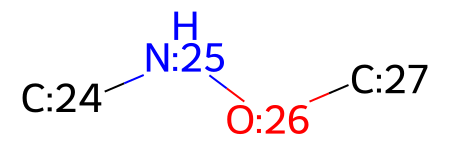

In [23]:
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
print(reaction_center_empty_smi[:10])
mol = Chem.MolFromSmiles(reaction_center_empty_smi[6])
mol

In [9]:
print(reaction_center_empty_num)
print(multi_frag)
print(len(single_frag_len))
print(ns_cnt)

188135
290331
1431317
509108


In [29]:
print(np.mean(single_frag_len))
print(np.mean(single_frag_atoms_len))
print(np.mean(multi_frag_atoms_len))

5.640918818123448
1.2804032929113536
2.862615428597015


In [1]:
mask_analysis

NameError: name 'mask_analysis' is not defined

In [8]:
reaction_center_uni_count = [len(rcenter) for rcenter in mol_dict.values()]

In [120]:
big_ones = [(inchi, rcenter) for inchi, rcenter in mol_dict.items() if len(rcenter) > 1]

In [121]:
len(big_ones)

89072

In [126]:
big_ones[100]

('InChI=1S/C2H5ClO/c1-4-2-3/h2H2,1H3',
 {'0', '01', '02', '023', '03', '1', '12', '2', '23', '3'})

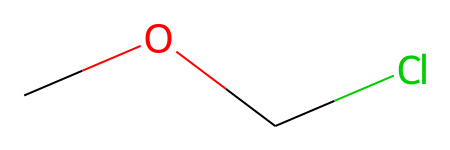

In [127]:
Chem.MolFromInchi(big_ones[100][0])

Unique Reaction Center Count:
                   0
count  676478.000000
mean        1.256039
std         1.325701
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       263.000000


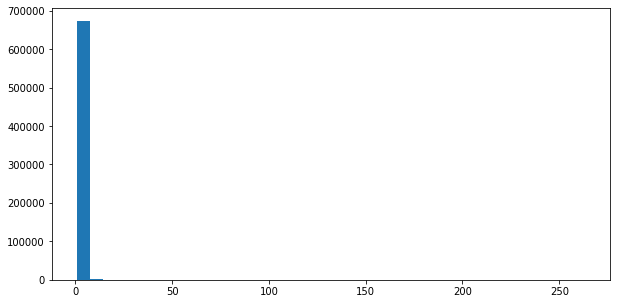

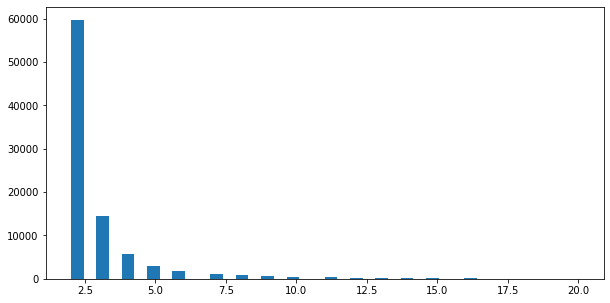

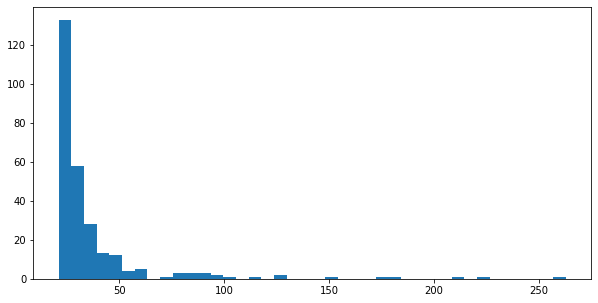

In [12]:
print("Unique Reaction Center Count:")
print(pd.DataFrame(reaction_center_uni_count).describe())
plt.rcParams["figure.figsize"] = (10, 5)
plt.hist(reaction_center_uni_count, bins = 40)
plt.show()

plt.rcParams["figure.figsize"] = (10, 5)
plt.hist([i for i in reaction_center_uni_count if i > 1 and i <= 20], bins = 40)
plt.show()

plt.rcParams["figure.figsize"] = (10, 5)
plt.hist([i for i in reaction_center_uni_count if i > 20], bins = 40)
plt.show()

In [82]:
print("Reaction Center Masking Ratio :")
print(pd.DataFrame(reaction_ratio).describe())


Reaction Center Masking Ratio :
                  0
count  1.910931e+06
mean   1.257218e-01
std    1.403078e-01
min    0.000000e+00
25%    4.761905e-02
50%    8.333333e-02
75%    1.428571e-01
max    1.000000e+00


In [83]:
print("Reaction Center w/ 1-hop neighbours Masking Ratio :")
print(pd.DataFrame(one_hop_r).describe())


Reaction Center w/ 1-hop neighbours Masking Ratio :
                  0
count  1.910931e+06
mean   3.050438e-01
std    2.500344e-01
min    0.000000e+00
25%    1.379310e-01
50%    2.352941e-01
75%    4.000000e-01
max    1.000000e+00


In [84]:
print("Reaction Center w/ 2-hop neighbours Masking Ratio :")
print(pd.DataFrame(two_hop_r).describe())

Reaction Center w/ 2-hop neighbours Masking Ratio :
                  0
count  1.910931e+06
mean   4.576759e-01
std    2.980482e-01
min    0.000000e+00
25%    2.380952e-01
50%    4.000000e-01
75%    6.551724e-01
max    1.000000e+00


In [85]:
print("Reaction Center w/ 3-hop neighbours Masking Ratio :")
print(pd.DataFrame(three_hop_r).describe())


Reaction Center w/ 3-hop neighbours Masking Ratio :
                  0
count  1.910931e+06
mean   5.833626e-01
std    3.197674e-01
min    0.000000e+00
25%    3.478261e-01
50%    5.833333e-01
75%    8.888889e-01
max    1.000000e+00


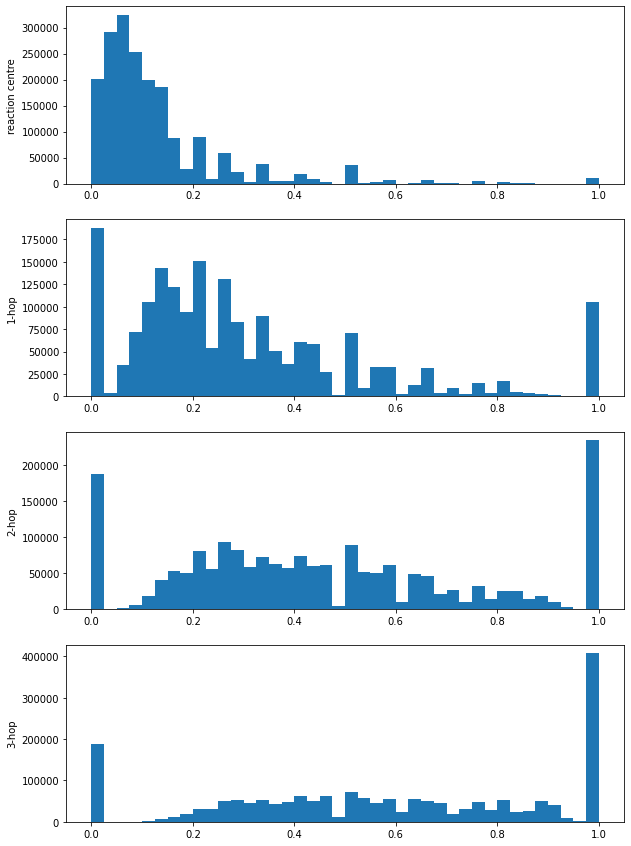

In [129]:
plt.rcParams["figure.figsize"] = (10, 15)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
ax1.hist(reaction_ratio, bins = 40)
ax1.set_ylabel("reaction centre")
ax2.hist(one_hop_r, bins = 40)
ax2.set_ylabel("1-hop")
ax3.hist(two_hop_r, bins = 40)
ax3.set_ylabel("2-hop")
ax4.hist(three_hop_r, bins = 40)
ax4.set_ylabel("3-hop")
plt.show()

In [15]:
x = pd.read_csv(USPTO_CONFIG.path)

In [19]:
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

In [27]:
def plot(i):
    full_react = x.iloc[i]['reactant'] + '>>' + x.iloc[i]['product']
    react_mol = AllChem.ReactionFromSmarts(full_react)
#    d2d = Draw.MolDraw2DCairo(800,300)
#    d2d.DrawReaction(react_mol)
    return react_mol
    

In [78]:
i = 39



50


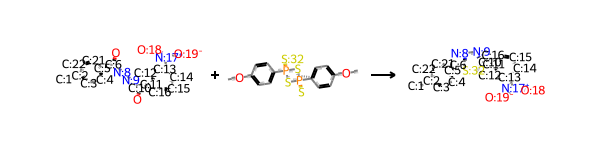

In [90]:
react_mol = plot(i)
print(i)
# d2d = Draw.MolDraw2DCairo(800,300)
# d2d.DrawReaction(react_mol, highlightByReactant=True)
# png = d2d.GetDrawingText()
# png
i += 1

react_mol